In [1]:
import numpy as np

from math import isclose

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy as sp
from scipy.interpolate import UnivariateSpline
from scipy import fftpack
from scipy import optimize as opt

import pylab as pb 
from mpl_toolkits.mplot3d import Axes3D

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



The maximum wind speed predicted to occur every 50 years is: 32.97989844019469


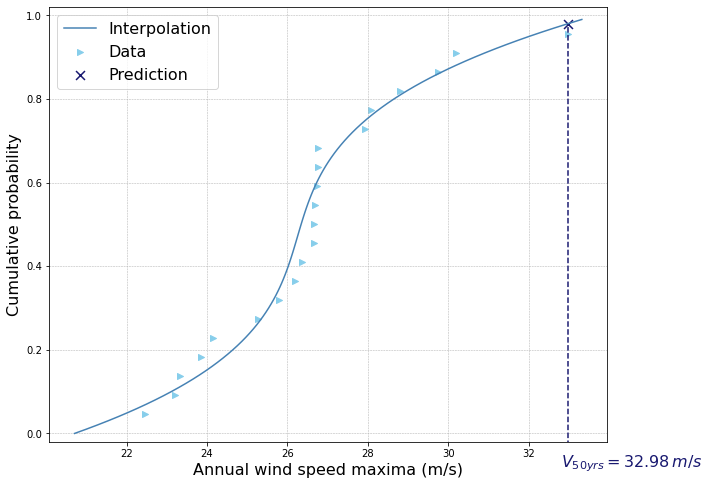

In [2]:
max_speeds = np.load('max-speeds.npy') #Load the dataset
years_nb = max_speeds.shape[0]

cprob = (np.arange(years_nb)+1)/(years_nb + 1) #Cumulative probability
max_speeds.sort() #Sort maximum speeds
quantile_func = UnivariateSpline(cprob, max_speeds) #Use UnivariateSpline to define a quantile function 

#Fit the data
nprob = np.arange(0, 1, 0.01)
fitted_max_speeds = quantile_func(nprob)

#Estimate max speed
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
print("The maximum wind speed predicted to occur every 50 years is:", fifty_wind) 

#Plot results
plt.figure(figsize=(10,8))
plt.scatter(max_speeds, cprob, marker='>', color='skyblue', label='Data')
plt.plot(fitted_max_speeds, nprob, c='steelblue', label='Interpolation')
plt.scatter(fifty_wind, fifty_prob, marker='x', color='midnightblue', s=80, label='Prediction')
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], '--', color = 'midnightblue')
plt.text(32.8, -0.08, '$V_{50yrs} = %.2f \, m/s$' % fifty_wind,color = 'midnightblue', fontsize = 16)
plt.ylim(-0.02,1.02)
plt.xlabel('Annual wind speed maxima (m/s)', fontsize=16) 
plt.ylabel('Cumulative probability', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.grid(linestyle="--", linewidth=0.5)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0, 0.5, 'Temperature [°C]')

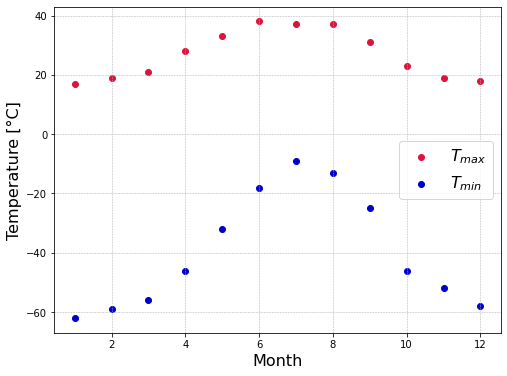

In [3]:
maxtemp = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
mintemp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
m = np.arange(1,13)

#Plot temperature extremes
plt.figure(figsize=(8,6))
plt.scatter(m, maxtemp, color='crimson', label='$T_{max}$')
plt.scatter(m, mintemp, color='mediumblue', label='$T_{min}$')
plt.legend(loc='best', fontsize=16)
plt.grid(linestyle="--", linewidth=0.5)
plt.xlabel('Month', size= 16)
plt.ylabel('Temperature [°C]', size= 16)

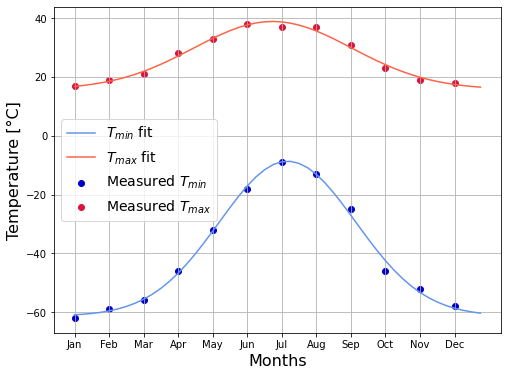

In [4]:
#Define a function that can describe min and max temperatures--> Looking at the plot above one can see that
#                                                                their distrib can be described by a gaussian

def f(x, mu, sigma, N, yshift):
    g = N*np.exp(-((x-mu)**2/(2*sigma**2))) + yshift
    return g;

#Fit this function to the data with scipy.optimize.curve_fit()
x = np.arange(1,13,0.25)
popt_max, pcov_max = sp.optimize.curve_fit(f, m, maxtemp)
popt_min, pcov_min = sp.optimize.curve_fit(f, m, mintemp)

#Plot the result

plt.figure(figsize=(8,6))
plt.scatter(m, mintemp, color='mediumblue', label='Measured $T_{min}$')
plt.scatter(m, maxtemp, color='crimson', label='Measured $T_{max}$')

plt.plot(x, f(x, *popt_min), c='cornflowerblue', label='$T_{min}$ fit')
plt.plot(x, f(x, *popt_max), c='tomato', label='$T_{max}$ fit')
plt.legend(loc='best', fontsize=14)
plt.xlabel('Months', size= 16)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(m,months)
plt.ylabel('Temperature [°C]', size= 16)
plt.grid('-.')
plt.show()


The fit seems reasonable. However, we expect that both $T_{min}$ and $T_{max}$ will reach their max value in the same month but  when computing the time offset:

In [5]:
#Is the time offset for min and max temperatures the same within the fit accuracy?
perr_min = np.sqrt(np.diag(pcov_min))[0]
perr_max = np.sqrt(np.diag(pcov_max))[0]
err_diff = np.sqrt(perr_max**2 + perr_min**2)

print("Time offset between the two fit: \n")
print("Mean of T_min gaussian =", popt_min[0], '+/-', perr_min)
print("Mean of T_max gaussian =", popt_max[0], '+/-', perr_max)
print("The time offset is ",abs(popt_max[0]-popt_min[0]), '+/-', err_diff)
print("The compatibility between the two means is", abs(popt_max[0]-popt_min[0])/err_diff, "which is quite big within the fit accuracy.")

Time offset between the two fit: 

Mean of T_min gaussian = 7.164525950817357 +/- 0.04720699217490772
Mean of T_max gaussian = 6.735815371325534 +/- 0.07946791671905995
The time offset is  0.42871057949182223 +/- 0.0924318662468158
The compatibility between the two means is 4.638125323003428 which is quite big within the fit accuracy.


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


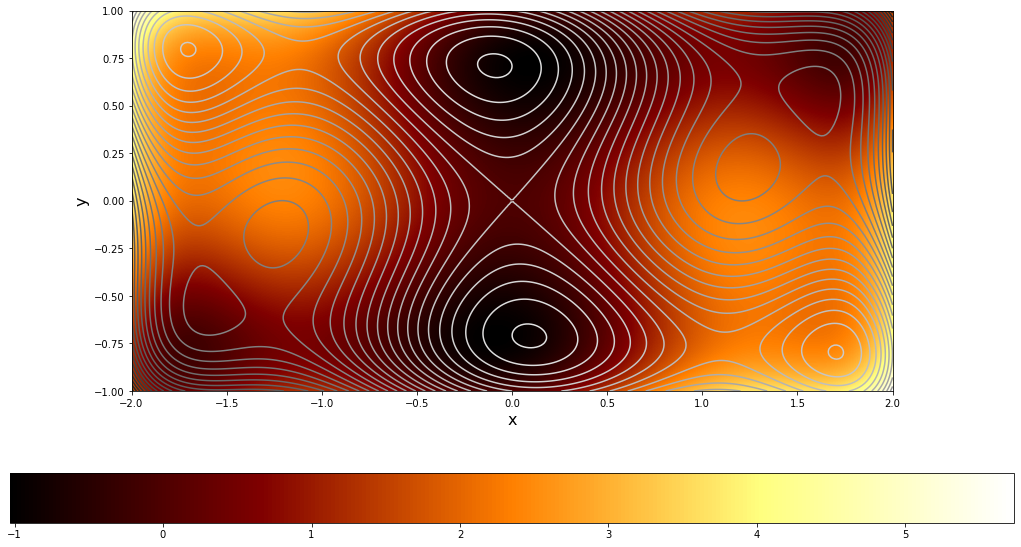

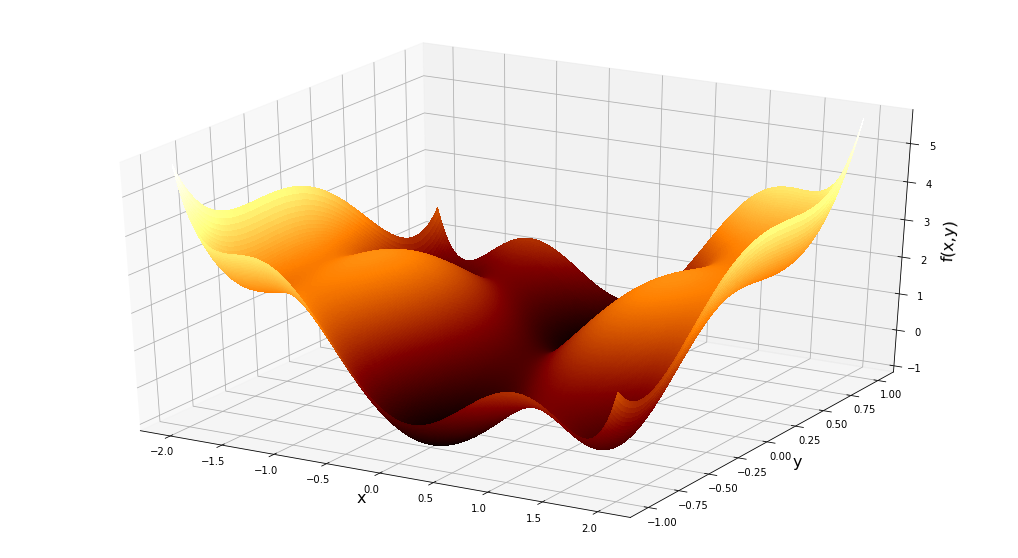

In [6]:
def sixhump(v):
    x,y = v
    return ( (4 - 2.1*x**2 + x**4/3)*x**2 + x*y + (4*y**2 - 4)*y**2 )

x = np.linspace(-2,2,300) #restrict variable to -2<x<2
y = np.linspace(-1,1,300) #and -1<y<1

#Use numpy.meshgrid() and pylab.imshow() to find visually the regions
xg, yg = np.meshgrid(x, y)
fg = sixhump([xg, yg])
heights = np.arange(-2, 7, 0.2)

#2D image plot
pb.figure(figsize=(18,10))
img = pb.imshow(fg, cmap='afmhot',extent=[-2, 2, -1, 1])
pb.colorbar(img, orientation='horizontal')
pb.contour(xg, yg, fg, levels=heights, cmap='binary')
pb.xlabel("x", fontsize=16)
pb.ylabel("y", fontsize=16)
pb.show()

#3D surface plot
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, fg, rstride=1, cstride=1, cmap='afmhot', linewidth=0, antialiased=False)

ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_zlabel("f(x,y)", fontsize=16)
plt.show()

From these graphs we can see that there are 6 local minima and one saddle point. The global minima seems to be either in the region $x \in [-0.25, 0.25]$, $y \in [0.50,1.0]$ or in the $x \in [-0.25, 0.25]$, $y \in [-0.50, -1.0]$ region. The value of the function seems to be the same in those regions.

In [7]:
#Use scipy.optimize.minimize(), trying out several of its methods

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA' , 'SLSQP']

#Starting point of minimization method
x0 = [np.random.uniform(-2,2), np.random.uniform(-1,1)]
print("Using", x0, "as starting point \n")

#trial of different methods
for i in methods:
    res = sp.optimize.minimize(sixhump, x0, method = i)
    if res.success:
        minima = res.x
        print("with the", i , "method, the global minimum is: \n", minima)

Using [-0.376966187184967, -0.3924910880376824] as starting point 

with the Nelder-Mead method, the global minimum is: 
 [ 0.08988273 -0.71266959]
with the Powell method, the global minimum is: 
 [-0.08984201  0.71265633]
with the CG method, the global minimum is: 
 [ 0.08984193 -0.71265633]
with the BFGS method, the global minimum is: 
 [ 0.08984204 -0.71265641]
with the L-BFGS-B method, the global minimum is: 
 [ 0.0898418  -0.71265639]
with the TNC method, the global minimum is: 
 [ 0.08984026 -0.71265698]
with the COBYLA method, the global minimum is: 
 [-0.08986451  0.7126107 ]
with the SLSQP method, the global minimum is: 
 [ 0.08979154 -0.71263242]


We can see that depending on the method adoperated and the starting point the values obtained are different. Most noticeably, for some x0 it may happen to "get stuck" in other minima, which are clearly only local minima. Thus, just applying any method without an accurate choice of the starting point won't guarantee to find of the global minimum.

In [8]:
#How many global minima are there, and what is the function value at those points?

#Select starting points close to minima based on previous plots
x_zeros = [[-1.75,0.75], [0.0,0.75], [1.75,0.75], [-1.75,-0.75], [0.0,-0.75], [1.75,-0.75]]
minima = [] 

glmin = 0 
f_glmin = 0
glmin2 = 0

for x0 in x_zeros:
    res = sp.optimize.minimize(sixhump, x0) 
    if res.success:        #success is Boolean flag indicating if the optimizer exited successfully 
        minimum = res.x    #solution of the optimization
        f_minim = sixhump(minimum)  #value of func in minimum found
        minima.append(minimum)
        if f_minim < f_glmin: #check if min found is local or global
            f_glmin = f_minim
            glmin = minimum

#To check if the function assumes same value as global min in other points            
for m in minima:
    if isclose(f_glmin, sixhump(m)) and not np.allclose(m, glmin):
        glmin2 = m            

print("The six minima of the function are:")
for i in range(len(minima)):
    print(minima[i], "where the value of the function is ", sixhump(minima[i]))
            
print("\n", "Thus the global minima are:")
print("x_min1, y_min1 =", glmin, "and", glmin2)
print("where the function's value is: ", f_glmin)


The six minima of the function are:
[-1.70360664  0.79608374] where the value of the function is  -0.21546382438332778
[-0.08984201  0.71265641] where the value of the function is  -1.031628453489877
[-0.08984197  0.71265632] where the value of the function is  -1.0316284534898161
[ 0.08984197 -0.71265632] where the value of the function is  -1.0316284534898161
[ 0.08984201 -0.71265641] where the value of the function is  -1.0316284534898772
[ 1.70360664 -0.79608374] where the value of the function is  -0.21546382438332778

 Thus the global minima are:
x_min1, y_min1 = [ 0.08984201 -0.71265641] and [-0.08984197  0.71265632]
where the function's value is:  -1.0316284534898772


Since $f(x,y)$ is invariant under a simultaneous change of sign for both x and y, we know that the global minima are actually two: as a matter of fact the function assumes the same value in both $[0.08984201,  -0.71265641]$ and $[-0.08984201,  0.71265641]$ which are both global minima. 

In [9]:
#What happens for an initial guess of  (𝑥,𝑦)=(0,0)?

res_00 = sp.optimize.minimize(sixhump, [0,0])
if res.success:
    min_00 = res_00.x
    print(min_00)


[0. 0.]


Since $[0,0]$ is a saddle point scipy.optimize.minimize() "gets stuck" when choosing it as starting point

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

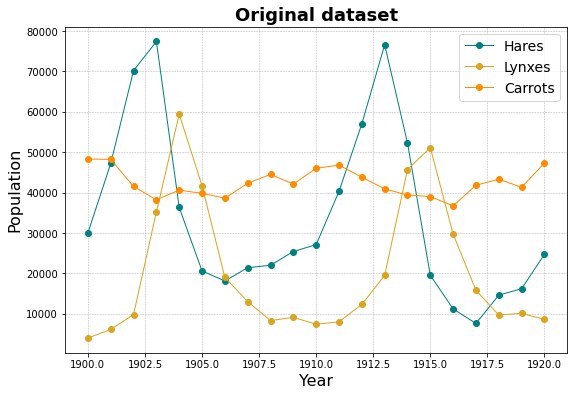

In [10]:
#Load the data
data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T

#Plot the data
plt.figure(figsize=(9,6))
plt.plot(year, hares, 'teal', marker='o', linewidth=1, label='Hares')
plt.plot(year, lynxes, 'goldenrod', marker='o', linewidth=1, label='Lynxes') 
plt.plot(year, carrots, 'darkorange', marker='o', linewidth=1, label='Carrots')
plt.grid(linestyle="--", linewidth=0.5)
plt.legend(loc='best', fontsize=14)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Population", fontsize=16)
plt.title("Original dataset", fontsize=18, fontweight = "bold")
plt.show()

(<matplotlib.patches.Rectangle at 0x227a4482ca0>,
 (<matplotlib.patches.ConnectionPatch at 0x227a4348bb0>,
  <matplotlib.patches.ConnectionPatch at 0x227a4410e50>))

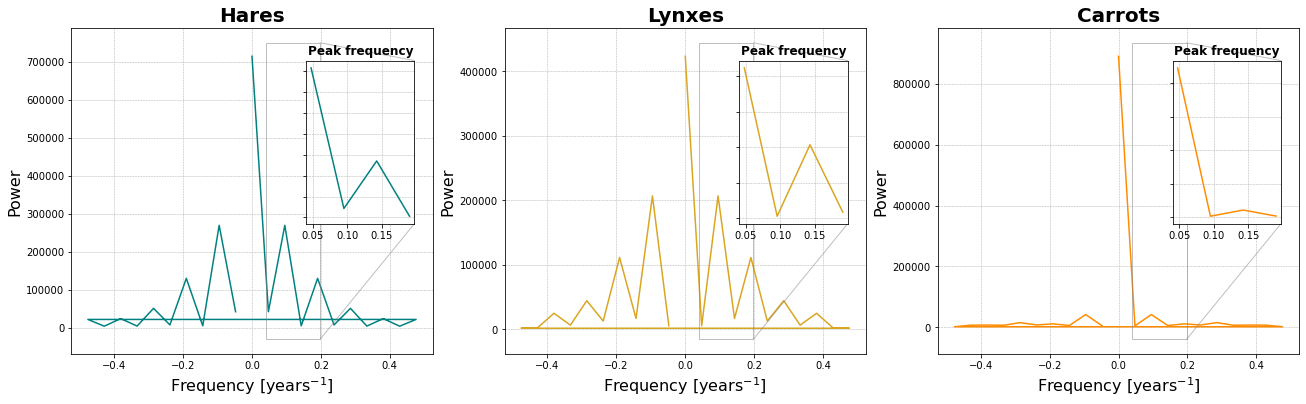

In [11]:
time_step = 1 #data is recorded year by year

# The FFT of the signals
hares_fft = fftpack.fft(hares) 
lynxes_fft = fftpack.fft(lynxes)
carrots_fft = fftpack.fft(carrots)

# And the power spectra 
h_power = np.abs(hares_fft)
l_power = np.abs(lynxes_fft)
c_power = np.abs(carrots_fft) 

# The corresponding frequencies
h_sample_freq = fftpack.fftfreq(hares.size, d=time_step)
l_sample_freq = fftpack.fftfreq(lynxes.size, d=time_step)
c_sample_freq = fftpack.fftfreq(carrots.size, d=time_step)

# Find the peak frequencies
#hares
h_pos_mask = np.where(h_sample_freq > 0)
h_freqs = h_sample_freq[h_pos_mask]
h_peak_freq = h_freqs[h_power[h_pos_mask].argmax()]
#lynxes
l_pos_mask = np.where(l_sample_freq > 0)
l_freqs = l_sample_freq[l_pos_mask]
l_peak_freq = l_freqs[l_power[l_pos_mask].argmax()]
#carrots
c_pos_mask = np.where(c_sample_freq > 0)
c_freqs = c_sample_freq[c_pos_mask]
c_peak_freq = c_freqs[c_power[c_pos_mask].argmax()]

#Results
fig = plt.figure(figsize=(22,6))
axh = fig.add_subplot(1,3,1)
axl = fig.add_subplot(1,3,2)
axc = fig.add_subplot(1,3,3)

# Plots for hares
#FFT power
axh.set_title('Hares', fontsize=20, fontweight='bold')
axh.plot(h_sample_freq, h_power, 'teal')
axh.set_xlabel('Frequency [years$^{-1}$]', fontsize=16)
axh.set_ylabel('Power', fontsize=16)
axh.grid(linestyle="--", linewidth=0.5)
#inner plot to show the peak frequency
hins = axh.inset_axes([0.65, 0.4, 0.3, 0.5])
hins.set_title('Peak frequency',fontsize=12, fontweight='bold')
hins.plot(h_freqs[:4], h_power[:4],'teal')
hins.set_yticklabels('')
hins.grid(linestyle="--", linewidth=0.5)
axh.indicate_inset_zoom(hins)

# Plots for lynxes
#FFT power
axl.set_title('Lynxes', fontsize=20, fontweight='bold')
axl.plot(l_sample_freq, l_power, 'goldenrod')
axl.set_xlabel('Frequency [years$^{-1}$]', fontsize=16)
axl.set_ylabel('Power', fontsize=16)
axl.grid(linestyle="--", linewidth=0.5)
#inner plot to show the peak frequency
lins = axl.inset_axes([0.65, 0.4, 0.3, 0.5])
lins.set_title('Peak frequency',fontsize=12, fontweight='bold')
lins.plot(l_freqs[:4], l_power[:4],'goldenrod')
lins.set_yticklabels('')
lins.grid(linestyle="--", linewidth=0.5)
axl.indicate_inset_zoom(lins)

# Plots for carrots
#FFT power
axc.set_title('Carrots', fontsize=20, fontweight='bold')
axc.plot(c_sample_freq, c_power, 'darkorange')
axc.set_xlabel('Frequency [years$^{-1}$]', fontsize=16)
axc.set_ylabel('Power', fontsize=16)
axc.grid(linestyle="--", linewidth=0.5)
#inner plot to show the peak frequency
cins = axc.inset_axes([0.65, 0.4, 0.3, 0.5])
cins.set_title('Peak frequency',fontsize=12, fontweight='bold')
cins.plot(c_freqs[:4], c_power[:4],'darkorange')
cins.set_yticklabels('')
cins.grid(linestyle="--", linewidth=0.5)
axc.indicate_inset_zoom(cins)

In [12]:
#Periodicity analysis:
print('Frequency of the peak for hares=', h_peak_freq, 'yr^(-1)=> Period T =', 1/h_peak_freq, 'yrs.')
print('Frequency of the peak for lynxes=', l_peak_freq, 'yr^(-1)=> Period T =', 1/l_peak_freq, 'yrs.')
print('Frequency of the peak for carrots=', c_peak_freq, 'yr^(-1)=> Period T =', 1/c_peak_freq, 'yrs.')

Frequency of the peak for hares= 0.09523809523809523 yr^(-1)=> Period T = 10.5 yrs.
Frequency of the peak for lynxes= 0.09523809523809523 yr^(-1)=> Period T = 10.5 yrs.
Frequency of the peak for carrots= 0.09523809523809523 yr^(-1)=> Period T = 10.5 yrs.


C:\Users\Francesca\anaconda3\envs\HLP\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Francesca\anaconda3\envs\HLP\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Francesca\anaconda3\envs\HLP\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


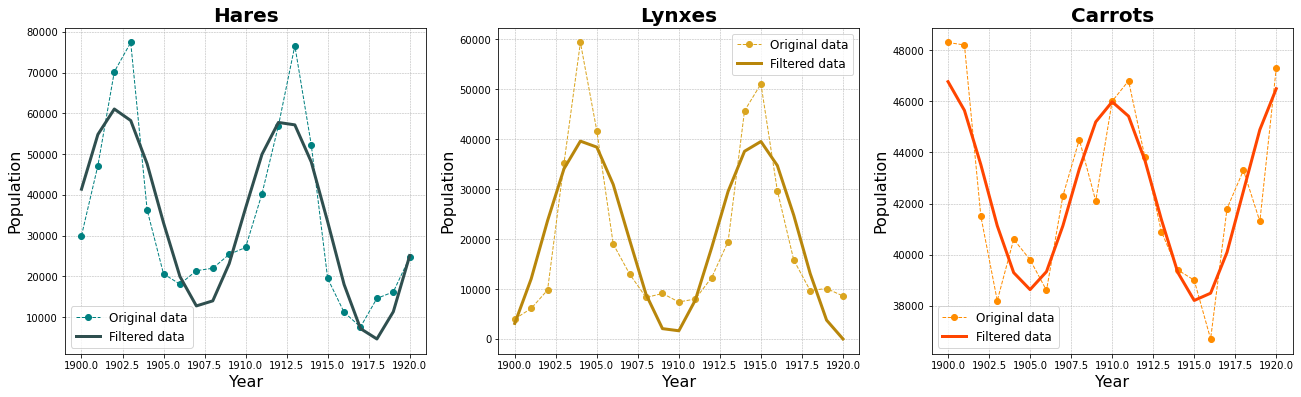

In [13]:
#Filter signal for hares
h_high_freq_fft = hares_fft.copy()
h_high_freq_fft[np.abs(h_sample_freq) > h_peak_freq] = 0
h_filtered_sig = fftpack.ifft(h_high_freq_fft)

#Filter signal for lynxes
l_high_freq_fft = lynxes_fft.copy()
l_high_freq_fft[np.abs(l_sample_freq) > l_peak_freq] = 0
l_filtered_sig = fftpack.ifft(l_high_freq_fft)

#Filter signal for carrots
c_high_freq_fft = carrots_fft.copy()
c_high_freq_fft[np.abs(c_sample_freq) > c_peak_freq] = 0
c_filtered_sig = fftpack.ifft(c_high_freq_fft)

#Results
fig = plt.figure(figsize=(22,6))
axh = fig.add_subplot(1,3,1)
axl = fig.add_subplot(1,3,2)
axc = fig.add_subplot(1,3,3)
#hares
axh.set_title('Hares', fontsize=20, fontweight='bold')
axh.grid(linestyle="--", linewidth=0.5)
axh.plot(year, hares, 'teal', marker='o',linestyle='--', linewidth=1, label='Original data')
axh.plot(year, h_filtered_sig, linewidth=3, color='darkslategray', label='Filtered data')
axh.set_xlabel('Year',fontsize=16)
axh.set_ylabel('Population',fontsize=16)
axh.legend(loc='best',fontsize=12)
#lynxes
axl.set_title('Lynxes', fontsize=20, fontweight='bold')
axl.grid(linestyle="--", linewidth=0.5)
axl.plot(year, lynxes, 'goldenrod', marker='o',linestyle='--', linewidth=1, label='Original data')
axl.plot(year, l_filtered_sig, linewidth=3, color='darkgoldenrod', label='Filtered data')
axl.set_xlabel('Year',fontsize=16)
axl.set_ylabel('Population',fontsize=16)
axl.legend(loc='best',fontsize=12)
#carrots
axc.set_title('Carrots', fontsize=20, fontweight='bold')
axc.grid(linestyle="--", linewidth=0.5)
axc.plot(year, carrots, 'darkorange', marker='o',linestyle='--', linewidth=1, label='Original data')
axc.plot(year, c_filtered_sig, linewidth=3, color='orangered', label='Filtered data')
axc.set_xlabel('Year',fontsize=16)
axc.set_ylabel('Population',fontsize=16)
axc.legend(loc='best', fontsize=12)

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Original image')

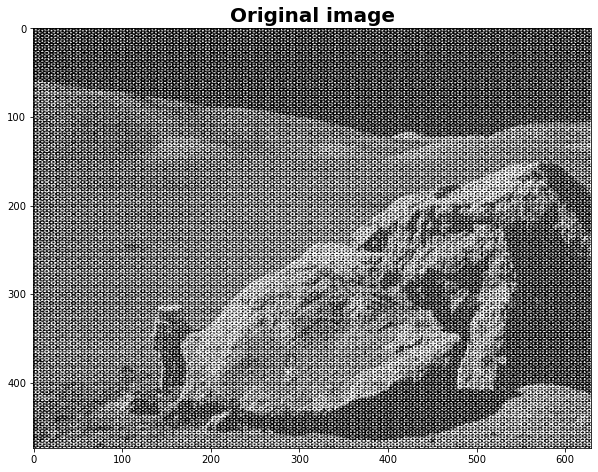

In [14]:
# Load the image using pylab.imread()
im = plt.imread('moonlanding.png')

pb.figure(figsize=(10,8))
pb.imshow(im, pb.cm.gray)
pb.title('Original image', fontsize=20, fontweight='bold')

Text(0.5, 1.0, '2D frequency spectrum')

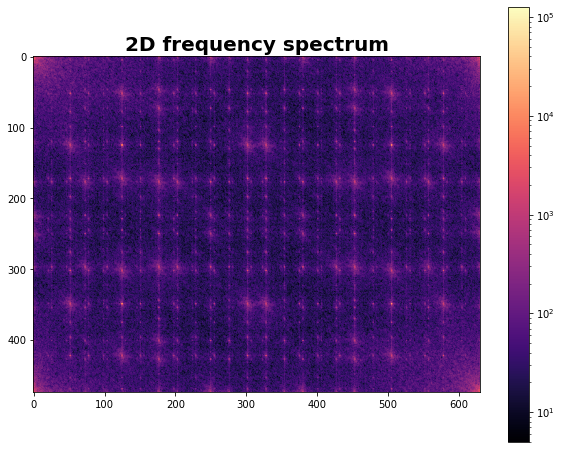

In [15]:
#Find and use the 2DFFT function in scipy.fftpack and plot the spectrum of the image. 

im_fft = fftpack.fft2(im)
def plot_spectrum(im_fft):
    pb.imshow(np.abs(im_fft), norm=colors.LogNorm(vmin=5), cmap='magma')
    pb.colorbar()

pb.figure(figsize=(10,8))
plot_spectrum(im_fft)
pb.title('2D frequency spectrum', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Filtered Spectrum')

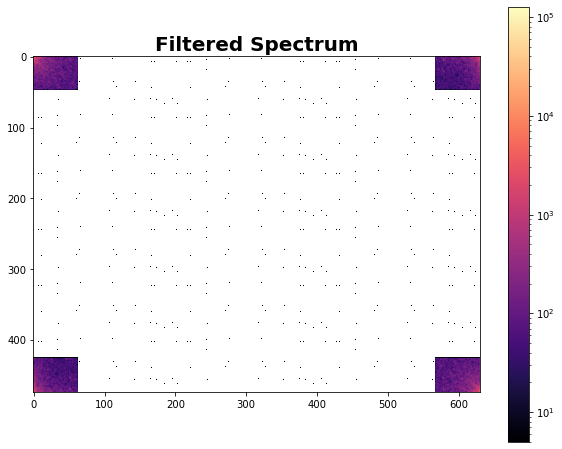

In [16]:
#The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero

threshold = 0.1 #threshold for cutting high frequency components
im_fft2 = im_fft.copy()

r, c = im_fft2.shape #r=rows c=columns


im_fft2[int(r*threshold):int(r*(1-threshold))] = 0 #Set to zero all r between r*threshold and r*(1-threshold)
im_fft2[:, int(c*threshold):int(c*(1-threshold))] = 0 #same thing for columns

plt.figure(figsize=(10,8))
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum',fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Reconstructed Image')

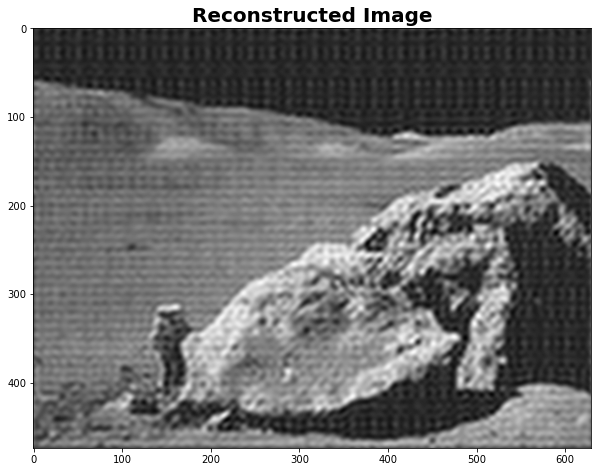

In [17]:
#Apply the inverse Fourier transform to see the resulting image.
im_new = fftpack.ifft2(im_fft2).real #keep only real part
plt.figure(figsize=(10,8))
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image',fontsize=20, fontweight='bold')